# Import Required Libraries
Importing required libraries for complex calculations, data visualization, and neural network implementation.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import qmc
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.integrate import simpson
import itertools
import time
from tqdm import tqdm
from google.colab import drive
import os

# Heston Characteristic Function
Solves for the Heston characteristic function to be used to solve for the price of the European call option.

In [ ]:
def heston_characteristic_function(j, phi, m, r, T, kappa, theta, sigma, rho, v0):
    if j == 1:
      u = 0.5
      b = kappa - rho*sigma
    elif j == 2:
      u = -0.5
      b = kappa
    i = 1j
    rspt = rho*sigma*phi*i

    d = np.sqrt((rspt - b)**2 - sigma**2 * (2*u * phi*i - phi**2))
    g = (b - rspt + d) / (b - rspt - d)
    C = r * phi * i * T + (kappa * theta) / sigma**2 * ((b - rspt + d) * T - 2 * np.log((1 - g * np.exp(d * T)) / (1 - g)))
    D = ((b - rspt + d) / sigma**2) * ((1 - np.exp(d * T)) / (1 - g * np.exp(d * T)))
    return np.exp(C + D * v0 + i * phi * np.log(m))

# Integration
Integration is a necessary step in computing the call option price.

In [ ]:
def integrand(phi, j, m, r, T, kappa, theta, sigma, rho, v0):
    i = 1j
    X = heston_characteristic_function(j, phi, m, r, T, kappa, theta, sigma, rho, v0)
    return np.real(X / (i * phi))

# Heston Probabilities
Solves for the probability equation Pj. For computational simplicity, integrals are calculated from a near-zero value to 100 (rather than infinity).

In [ ]:
def heston_probability(j, m, r, T, kappa, theta, sigma, rho, v0):
    phi_min = 1e-6
    phi_max = 100
    phi = np.linspace(phi_min, phi_max, 256)
    integral = simpson(integrand(phi, j, m, r, T, kappa, theta, sigma, rho, v0), x=phi)

    return 0.5 + integral / np.pi

# Heston Call Price Function
Calls probability function for j = 1 and j = 2. Uses probabilities to calculate call price.

In [ ]:
def heston_call_price(m, r, T, kappa, theta, sigma, rho, v0):
    P1 = heston_probability(1, m, r, T, kappa, theta, sigma, rho, v0)
    P2 = heston_probability(2, m, r, T, kappa, theta, sigma, rho, v0)
    return m * P1 - P2

# Generate Data
Generates data for all parameters between provided boundaries using Latin Hypercube Sampling. Filters out data which does not satisfy the Feller condition (to avoid variance and improve model training). Because filtering removes a large number of samples, 10x samples are generated. The generated data are saved to Google Drive to be used in future tests.

In [ ]:
def generate_heston_dataset_fixed_grid(path, n_samples=100000):
    log_moneyness_vals = ([-0.15,-0.12, -0.1, -0.08, -0.05, -0.04, -0.03, -0.02, -0.01, 0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21])
    T_vals = np.array([0.03, 0.05, 0.07, 0.09, 0.2, 0.5, 1.0, 2.0, 3.0])

    m_grid = np.exp(log_moneyness_vals)
    grid = list(itertools.product(m_grid, T_vals))

    sampler = qmc.LatinHypercube(d=5)
    sample = sampler.random(n=n_samples * 10)

    kappa = 1e-4 + sample[:, 0] * (2.0 - 1e-4)
    theta = 1e-2 + sample[:, 1] * (2.0 - 1e-2)
    sigma = 0.2 + sample[:, 2] * (0.6 - 0.2)
    rho = np.sin(np.pi * (sample[:, 3] - 0.5))
    v0 = np.exp(np.log(1e-3) + sample[:, 4] * (np.log(0.5) - np.log(1e-3)))

    all_params = np.stack([kappa, theta, sigma, rho, v0], axis=1)

    X_all = []
    filtered_params = []

    for params in tqdm(all_params, total=len(all_params), desc="Generating samples"):
        kappa, theta, sigma, rho, v0 = params
        if 2 * kappa * theta <= sigma**2:
            continue

        price_vec = []
        for m, T in grid:
            P = heston_call_price(m, r=0.0, T=T, kappa=kappa, theta=theta, sigma=sigma, rho=rho, v0=v0)
            price_vec.append([m,T,P])

        price_vec = np.clip(price_vec, 1e-8, None)
        if np.any(np.isnan(price_vec)) or np.any(np.isinf(price_vec)):
            continue

        prices = np.clip(price_vec, 1e-8, 1e3)
        X_all.append(prices)

        filtered_params.append([np.log(kappa), np.log(theta), sigma, rho, np.log(v0)])

        if len(X_all) >= n_samples:
            break

    X_all = np.array(X_all)
    filtered_params = np.array(filtered_params)

    S_K = X_all[:, :, 0]
    T_vals = X_all[:, :, 1]
    P_vals = X_all[:, :, 2]

    np.savez_compressed(path, S_K=S_K, T=T_vals, P=P_vals, y=filtered_params)

# Heston Dataset
Convert data to PyTorch tensors.

In [ ]:
class HestonDataset(Dataset):
    def __init__(self, X_or_path, y=None):
        if isinstance(X_or_path, str):
            data = np.load(X_or_path)
            S_K = data["S_K"]
            T = data["T"]
            P = data["P"]
            y = data["y"]
            X = np.hstack([S_K, T, P])
        else:
            X = X_or_path
            assert y is not None, "Must provide 'y' when passing arrays directly"

        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Heston Model Class
Class built to represent neural network. Built with 2 hidden layers of size 500. The MLP architecture is manually altered to compare the output and determine the optimal MLP.

In [ ]:
class HestonMLP(nn.Module):
    def __init__(self, input_size, output_size=5):
        super(HestonMLP, self).__init__()
        self.model = nn.Sequential(
        nn.Linear(input_size, 1000),
        nn.ReLU(),
        nn.Linear(1000, 1000),
        nn.ReLU(),
        nn.Linear(1000, output_size)
        )

    def forward(self, x):
        return self.model(x)

# Load or Generate Data
This code block checks to see if a generated file with the specified name exists in the user’s Google Drive. If that file exists, it will train the model on that dataset. If the file does not exist, it will generate data and save it in google drive.

In [ ]:
def main():
    path = "dataset.npz"
    drive.mount('/content/drive')
    if os.path.exists(path):
        print(f"Loading dataset from dataset.npz")
        dataset = HestonDataset(path)
    else:
        print(f"Generating dataset (n={100000}) and saving to dataset.npz")
        generate_heston_dataset_fixed_grid(path,100000)
        dataset = HestonDataset(path)

# Program Training
Main function continues by training the model using the previously generated dataset. Data is split into train and test data. Program trains model for 50 epochs and prints the train and validation loss at each epoch.

In [ ]:
    X, y_all = dataset.X, dataset.y
    print("X shape:", X.shape)
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X = X_scaler.fit_transform(X)
    y = y_scaler.fit_transform(y_all)

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    train_ds = HestonDataset(X_train, y_train)
    valid_ds = HestonDataset(X_valid, y_valid)
    test_ds = HestonDataset(X_test, y_test)


    train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
    valid_loader = DataLoader(valid_ds, batch_size=256, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_size = dataset.X.shape[1]
    model = HestonMLP(input_size=input_size, output_size=5)

    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.MSELoss()

    num_epochs = 50
    train_losses = []
    valid_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in valid_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

        val_loss /= len(valid_loader)
        valid_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] – Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

# Model Testing
Code block tests the neural network by comparing the predicted values against the true values and calculates a new option price with the predicted values. Function finally computes and prints the MSE and R2 scores before outputting graphs which visualize the accuracy of the model’s predictions. Function also plots the train and validation loss across epochs.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading dataset from dataset.npz
X shape: torch.Size([100000, 621])
Epoch [1/50] – Train Loss: 0.354939, Val Loss: 0.232820
Epoch [2/50] – Train Loss: 0.213875, Val Loss: 0.198944
Epoch [3/50] – Train Loss: 0.191323, Val Loss: 0.186992
Epoch [4/50] – Train Loss: 0.182634, Val Loss: 0.181695
Epoch [5/50] – Train Loss: 0.176857, Val Loss: 0.174428
Epoch [6/50] – Train Loss: 0.173163, Val Loss: 0.169711
Epoch [7/50] – Train Loss: 0.169944, Val Loss: 0.170873
Epoch [8/50] – Train Loss: 0.167735, Val Loss: 0.176785
Epoch [9/50] – Train Loss: 0.166297, Val Loss: 0.164375
Epoch [10/50] – Train Loss: 0.162503, Val Loss: 0.159816
Epoch [11/50] – Train Loss: 0.160722, Val Loss: 0.159242
Epoch [12/50] – Train Loss: 0.158801, Val Loss: 0.162981
Epoch [13/50] – Train Loss: 0.155605, Val Loss: 0.152617
Epoch [14/50] – Train Loss: 0.152510, Val Loss: 0.146800
Epoch [15/50] 

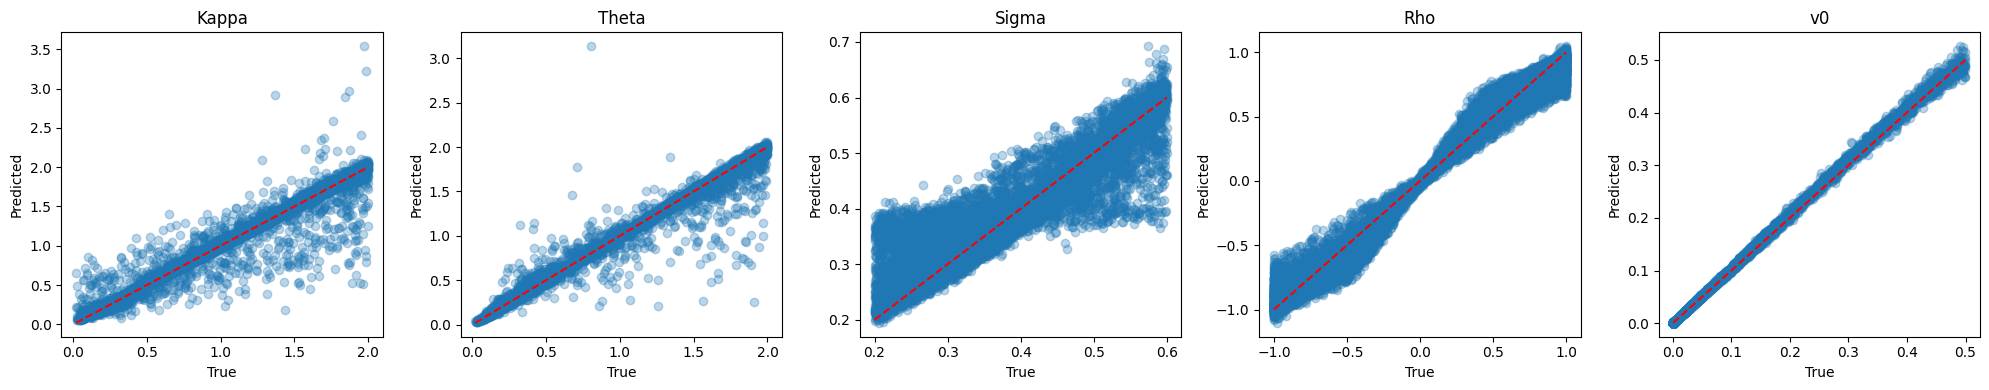

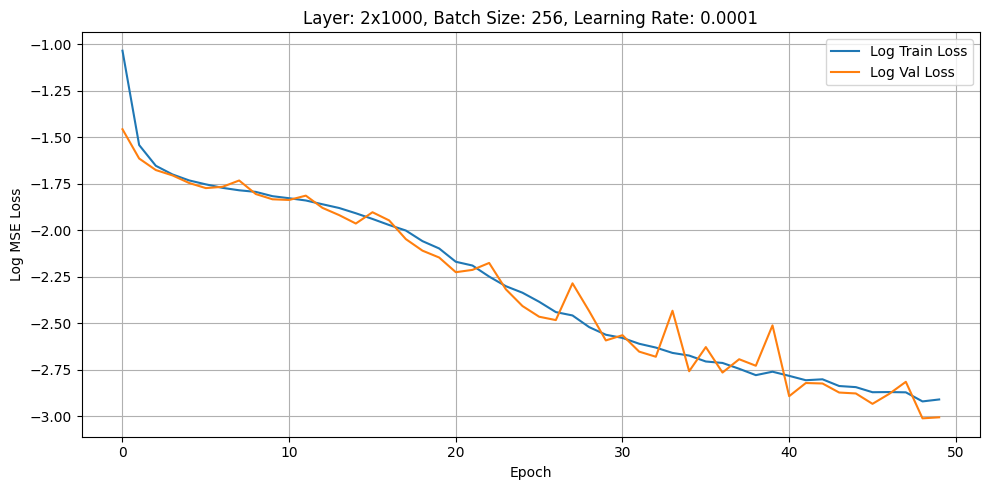

In [ ]:
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        preds_scaled = model(X_test_tensor).cpu().numpy()
        preds = y_scaler.inverse_transform(preds_scaled)
        y_true = y_scaler.inverse_transform(y_test)
        preds[:, 0] = np.exp(preds[:, 0])
        y_true[:, 0] = np.exp(y_true[:, 0])
        preds[:, 1] = np.exp(preds[:, 1])
        y_true[:, 1] = np.exp(y_true[:, 1])
        preds[:, 4] = np.exp(preds[:, 4])
        y_true[:, 4] = np.exp(y_true[:, 4])


        mse = np.mean((preds - y_true) ** 2, axis=0)
        r2 = r2_score(y_true, preds, multioutput='raw_values')
        param_names = ["Kappa", "Theta", "Sigma", "Rho", "v0"]

        print("\nParameter Prediction Performance:")
        for i, name in enumerate(param_names):
            print(f"{name}: MSE = {mse[i]:.6f}, R² = {r2[i]:.6f}")

        fig, axs = plt.subplots(1, 5, figsize=(20, 4))
        for i, ax in enumerate(axs):
            ax.scatter(y_true[:, i], preds[:, i], alpha=0.3)
            ax.plot([y_true[:, i].min(), y_true[:, i].max()],
                    [y_true[:, i].min(), y_true[:, i].max()], 'r--')
            ax.set_title(param_names[i])
            ax.set_xlabel("True")
            ax.set_ylabel("Predicted")
        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(10, 5))
        plt.plot(np.log(train_losses), label="Log Train Loss")
        plt.plot(np.log(valid_losses), label="Log Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Log MSE Loss")
        plt.title("Layer: 2x1000, Batch Size: 256, Learning Rate: 0.0001")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()






if __name__ == "__main__":
    main()